# Notebook: Predicción de precios (Tomate) — CRISP-DM

Este notebook guía paso a paso la construcción de un modelo de predicción de precios para frutas/hortalizas (ej. *Tomate*) usando la metodología **CRISP-DM**. Está comentado en español y contiene ejemplos con varios modelos:

- Prophet (modelo clásico de series temporales)
- Random Forest (modelo ML con características de rezago)
- LSTM (modelo deep learning para series de tiempo)

> Nota: este notebook está diseñado para ejecutarse en Google Colab o Jupyter. Asegúrate de ajustar la ruta del archivo CSV si lo cargas de forma distinta.


## 0) Instalación de dependencias

En Colab deberías ejecutar las siguientes celdas para instalar las librerías necesarias. Si ya las tienes, puedes omitir la instalación.


In [ ]:
# Instalación (descomenta si hace falta en tu entorno)
# En Google Colab: ejecutar estas celdas al principio
!pip install --quiet pystan~=2.19 prophet scikit-learn matplotlib seaborn pandas tqdm plotly
!pip install --quiet tensorflow>=2.0

print('Instalaciones (si fueron necesarias) completadas.')

## 1) Importar librerías y funciones útiles

A continuación importamos las librerías que usaremos en el notebook.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import plotly.express as px

# Para Prophet
from prophet import Prophet

# Para LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')
print('Librerías importadas')

Librerías importadas


## 2) Cargar y explorar el dataset

Aqui definimos la ruta del archivo CSV (el que subiste está en `/mnt/data/2016.csv`). El notebook intentará detectar el encoding y convertir columnas numéricas que usan coma decimal.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import glob, pandas as pd

# Ruta a la carpeta donde están tus CSV
ruta_carpeta = '/content/drive/MyDrive/Semestre 2025-2/CAPSTONE/agrochile/modelo IA'

# Buscar todos los CSV que terminen con año
archivos = sorted(glob.glob(ruta_carpeta + '/*.csv')) # Corrected pattern
print(f"Se encontraron {len(archivos)} archivos:", archivos)

# Leer y unir todos los años
lista_dfs = []
for archivo in archivos:
    df_temp = pd.read_csv(archivo, encoding='utf-8')
    df_temp['archivo_origen'] = archivo.split('/')[-1]
    lista_dfs.append(df_temp)

df = pd.concat(lista_dfs, ignore_index=True)
print('Shape final combinado:', df.shape)
df.head()

Se encontraron 9 archivos: ['/content/drive/MyDrive/Semestre 2025-2/CAPSTONE/agrochile/modelo IA/2016.csv', '/content/drive/MyDrive/Semestre 2025-2/CAPSTONE/agrochile/modelo IA/2017.csv', '/content/drive/MyDrive/Semestre 2025-2/CAPSTONE/agrochile/modelo IA/2018.csv', '/content/drive/MyDrive/Semestre 2025-2/CAPSTONE/agrochile/modelo IA/2019.csv', '/content/drive/MyDrive/Semestre 2025-2/CAPSTONE/agrochile/modelo IA/2020.csv', '/content/drive/MyDrive/Semestre 2025-2/CAPSTONE/agrochile/modelo IA/2021.csv', '/content/drive/MyDrive/Semestre 2025-2/CAPSTONE/agrochile/modelo IA/2022.csv', '/content/drive/MyDrive/Semestre 2025-2/CAPSTONE/agrochile/modelo IA/2023.csv', '/content/drive/MyDrive/Semestre 2025-2/CAPSTONE/agrochile/modelo IA/2024.csv']
Shape final combinado: (1712044, 15)


,Fecha,ID region,Region,Mercado,Subsector,Producto,Variedad / Tipo,Calidad,Unidad de comercializacion,Origen,Volumen,Precio minimo,Precio maximo,Precio promedio,archivo_origen
0,2016-01-04,5,Región de Valparaíso,Femacal de La Calera,Hortalizas y tubérculos,Acelga,Sin especificar,Primera,$/atado,Provincia de Quillota,160,"1999,9999","1999,9999","1999,9999",2016.csv
1,2016-01-04,9,Región de La Araucanía,Vega Modelo de Temuco,Hortalizas y tubérculos,Acelga,Sin especificar,Primera,$/docena de paquetes,Provincia de Cautín,10,"6000,0000","6000,0000","6000,0000",2016.csv
2,2016-01-04,13,Región Metropolitana de Santiago,Mercado Mayorista Lo Valledor de Santiago,Hortalizas y tubérculos,Acelga,Sin especificar,Primera,$/docena de atados,Región Metropolitana,204,"9999,9999","9999,9999","9999,9999",2016.csv
3,2016-01-04,16,Región de Ñuble,Terminal Hortofrutícola Agro Chillán,Hortalizas y tubérculos,Acelga,Sin especificar,Primera,$/docena de atados,Región Metropolitana,28,"10999,9999","12000,0000","11464,2857",2016.csv
4,2016-01-04,4,Región de Coquimbo,Terminal La Palmera de La Serena,Hortalizas y tubérculos,Acelga,Sin especificar,Primera,$/atado,Región de Coquimbo,960,"399,9999","419,9999","410,0000",2016.csv


In [ ]:
# # Ruta al archivo (ajusta si usas otro archivo)
# path = '/content/drive/MyDrive/Semestre 2025-2/CAPSTONE/agrochile/modelo IA/2016.csv'

# # Leer CSV con detección de encoding simple
# enc = None
# for e in ['utf-8', 'latin1', 'cp1252']:
#     try:
#         test = pd.read_csv(path, nrows=100, encoding=e)
#         enc = e
#         break
#     except Exception as e:
#         enc = None
# if enc is None:
#     raise FileNotFoundError(f'No se pudo abrir el archivo {path} con los encodings probados.')

# print('Encoding detectado:', enc)
# df = pd.read_csv(path, encoding=enc)
# print('Shape:', df.shape)
# print('\nColumnas disponibles:')
# print(df.columns.tolist())

# df.head()

Encoding detectado: utf-8
Shape: (195175, 14)

Columnas disponibles:
['Fecha', 'ID region', 'Region', 'Mercado', 'Subsector', 'Producto', 'Variedad / Tipo', 'Calidad', 'Unidad de comercializacion', 'Origen', 'Volumen', 'Precio minimo', 'Precio maximo', 'Precio promedio']


,Fecha,ID region,Region,Mercado,Subsector,Producto,Variedad / Tipo,Calidad,Unidad de comercializacion,Origen,Volumen,Precio minimo,Precio maximo,Precio promedio
0,2016-01-04,5,Región de Valparaíso,Femacal de La Calera,Hortalizas y tubérculos,Acelga,Sin especificar,Primera,$/atado,Provincia de Quillota,160,"1999,9999","1999,9999","1999,9999"
1,2016-01-04,9,Región de La Araucanía,Vega Modelo de Temuco,Hortalizas y tubérculos,Acelga,Sin especificar,Primera,$/docena de paquetes,Provincia de Cautín,10,"6000,0000","6000,0000","6000,0000"
2,2016-01-04,13,Región Metropolitana de Santiago,Mercado Mayorista Lo Valledor de Santiago,Hortalizas y tubérculos,Acelga,Sin especificar,Primera,$/docena de atados,Región Metropolitana,204,"9999,9999","9999,9999","9999,9999"
3,2016-01-04,16,Región de Ñuble,Terminal Hortofrutícola Agro Chillán,Hortalizas y tubérculos,Acelga,Sin especificar,Primera,$/docena de atados,Región Metropolitana,28,"10999,9999","12000,0000","11464,2857"
4,2016-01-04,4,Región de Coquimbo,Terminal La Palmera de La Serena,Hortalizas y tubérculos,Acelga,Sin especificar,Primera,$/atado,Región de Coquimbo,960,"399,9999","419,9999","410,0000"


### 2.1 Normalizar nombres de columnas y convertir valores numéricos

Renombraremos columnas para trabajar con nombres más compactos y convertiremos las columnas de precios (que usan coma decimal) a `float`.

In [ ]:
# Mapear columnas (ajusta si tu CSV tiene nombres distintos)
col_map = {
    'Fecha':'fecha',
    'Producto':'producto',
    'Variedad / Tipo':'variedad',
    'Mercado':'mercado',
    'Region':'region',
    'Precio promedio':'precio_promedio',
    'Precio minimo':'precio_minimo',
    'Precio maximo':'precio_maximo',
    'Volumen':'volumen'
}

# Aplicar renombrado sólo a las columnas que existan
df = df.rename(columns={k:v for k,v in col_map.items() if k in df.columns})

# Convertir fecha a datetime
df['fecha'] = pd.to_datetime(df['fecha'], errors='coerce')

# Función para convertir coma decimal a float
def comma_to_float(x):
    if pd.isna(x):
        return np.nan
    if isinstance(x, (int, float)):
        return x
    s = str(x).strip()
    # Reemplazar puntos como miles (si existen) y coma decimal por punto
    s = s.replace('.', '')
    s = s.replace(',', '.')
    try:
        return float(s)
    except:
        return np.nan

# Columnas de precio posibles
for c in ['precio_promedio','precio_minimo','precio_maximo']:
    if c in df.columns:
        df[c] = df[c].apply(comma_to_float)

print('Tipos luego de conversión:')
print(df.dtypes)

# Mostrar primeros registros
df.head()

Tipos luego de conversión:
fecha                         datetime64[ns]
ID region                              int64
region                                object
mercado                               object
Subsector                             object
producto                              object
variedad                              object
Calidad                               object
Unidad de comercializacion            object
Origen                                object
volumen                                int64
precio_minimo                        float64
precio_maximo                        float64
precio_promedio                      float64
archivo_origen                        object
dtype: object


,fecha,ID region,region,mercado,Subsector,producto,variedad,Calidad,Unidad de comercializacion,Origen,volumen,precio_minimo,precio_maximo,precio_promedio,archivo_origen
0,2016-01-04,5,Región de Valparaíso,Femacal de La Calera,Hortalizas y tubérculos,Acelga,Sin especificar,Primera,$/atado,Provincia de Quillota,160,1999.9999,1999.9999,1999.9999,2016.csv
1,2016-01-04,9,Región de La Araucanía,Vega Modelo de Temuco,Hortalizas y tubérculos,Acelga,Sin especificar,Primera,$/docena de paquetes,Provincia de Cautín,10,6000.0000,6000.0000,6000.0000,2016.csv
2,2016-01-04,13,Región Metropolitana de Santiago,Mercado Mayorista Lo Valledor de Santiago,Hortalizas y tubérculos,Acelga,Sin especificar,Primera,$/docena de atados,Región Metropolitana,204,9999.9999,9999.9999,9999.9999,2016.csv
3,2016-01-04,16,Región de Ñuble,Terminal Hortofrutícola Agro Chillán,Hortalizas y tubérculos,Acelga,Sin especificar,Primera,$/docena de atados,Región Metropolitana,28,10999.9999,12000.0000,11464.2857,2016.csv
4,2016-01-04,4,Región de Coquimbo,Terminal La Palmera de La Serena,Hortalizas y tubérculos,Acelga,Sin especificar,Primera,$/atado,Región de Coquimbo,960,399.9999,419.9999,410.0000,2016.csv


### 2.2 Productos disponibles

Listamos los productos únicos para que elijas cuál modelar (ejemplo: 'Tomate').

In [ ]:
print('Productos (muestra primeros 30):')
print(df['producto'].dropna().unique()[:30])

print('\nConteo por producto (top 20):')
print(df['producto'].value_counts().head(20))

Productos (muestra primeros 30):
['Acelga' 'Ají' 'Ajo' 'Albahaca' 'Apio' 'Arveja Verde' 'Plátano'
 'Berenjena' 'Betarraga' 'Brócoli' 'Cebolla' 'Ciboulette' 'Cereza'
 'Choclo' 'Cilantro' 'Ciruela' 'Coliflor' 'Damasco' 'Durazno' 'Espinaca'
 'Frutilla' 'Haba' 'Kiwi' 'Lechuga' 'Limón' 'Mandarina' 'Mango' 'Melón'
 'Naranja' 'Nectarín']

Conteo por producto (top 20):
producto
Manzana      117036
Palta         97958
Limón         94726
Tomate        90817
Lechuga       90070
Cebolla       77227
Pimiento      75317
Naranja       51185
Papa          48118
Repollo       44287
Pera          42854
Plátano       41651
Piña          39637
Nectarín      35668
Zanahoria     33854
Mandarina     33842
Zapallo       33063
Frutilla      31138
Durazno       30804
Brócoli       29911
Name: count, dtype: int64


## 3) Preparación de la serie temporal para un producto

Definimos una función que filtra por producto (y opcionalmente por variedad o región/mercado) y devuelve una serie agregada por día (precio promedio).

In [ ]:
def preparar_serie(df, producto, variedad=None, region=None, mercado=None, agg='mean'):
    dfp = df.copy()
    dfp = dfp[dfp['producto'].str.lower().str.contains(producto.lower(), na=False)]
    if variedad and 'variedad' in dfp.columns:
        dfp = dfp[dfp['variedad'].str.lower().str.contains(variedad.lower(), na=False)]
    if region and 'region' in dfp.columns:
        dfp = dfp[dfp['region'].str.lower().str.contains(region.lower(), na=False)]
    if mercado and 'mercado' in dfp.columns:
        dfp = dfp[dfp['mercado'].str.lower().str.contains(mercado.lower(), na=False)]

    # Asegurar que exista la columna precio_promedio
    if 'precio_promedio' not in dfp.columns:
        raise ValueError('No se encontró la columna precio_promedio en el dataset filtrado')

    # Agrupar por fecha (día) y opcionalmente por mercado
    series = dfp.groupby(['fecha']).agg({'precio_promedio': agg}).rename(columns={'precio_promedio':'precio'}).reset_index()
    series = series.sort_values('fecha').set_index('fecha')
    return series

# Ejemplo rápido con 'Tomate' (ajusta nombre exacto según tu CSV)
producto_ej = 'Tomate'
serie_tomate = preparar_serie(df, producto_ej)
print('Registros en la serie (ejemplo):', serie_tomate.shape)
serie_tomate.head()

Registros en la serie (ejemplo): (2239, 1)


,precio
fecha,
2016-01-04,8458.332541
2016-01-05,8330.405540
2016-01-06,8167.404995
2016-01-07,6465.274972
2016-01-08,6438.341424


### 3.1 Visualizar la serie (precio promedio diario)

Mostramos la serie del producto seleccionado y su comportamiento.

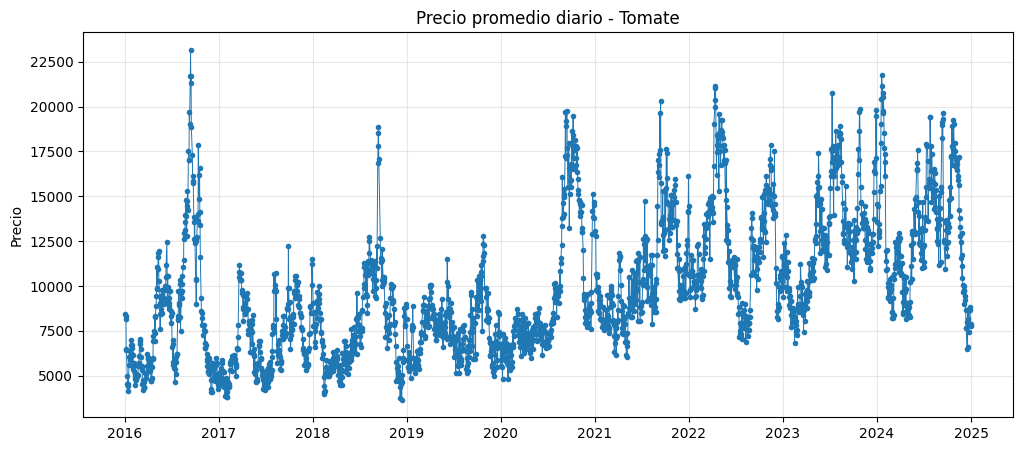

In [ ]:
import matplotlib.dates as mdates

if len(serie_tomate)>0:
    plt.figure(figsize=(12,5))
    plt.plot(serie_tomate.index, serie_tomate['precio'], marker='.', linewidth=0.7)
    plt.title(f'Precio promedio diario - {producto_ej}')
    plt.ylabel('Precio')
    plt.grid(alpha=0.3)
    plt.show()
else:
    print('La serie está vacía. Revisa el nombre del producto.')

## 4) Modelo 1: Prophet (recomendado para series temporales)

Entrenaremos Prophet sobre la serie agregada y haremos predicción para un periodo de prueba (ej: diciembre 2016 o noviembre 2025).

DEBUG:cmdstanpy:input tempfile: /tmp/tmpyobo_zzh/lu_r0tgz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyobo_zzh/2e6r1why.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10160', 'data', 'file=/tmp/tmpyobo_zzh/lu_r0tgz.json', 'init=/tmp/tmpyobo_zzh/2e6r1why.json', 'output', 'file=/tmp/tmpyobo_zzh/prophet_modelir1pi9z0/prophet_model-20251010031207.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:12:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:12:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


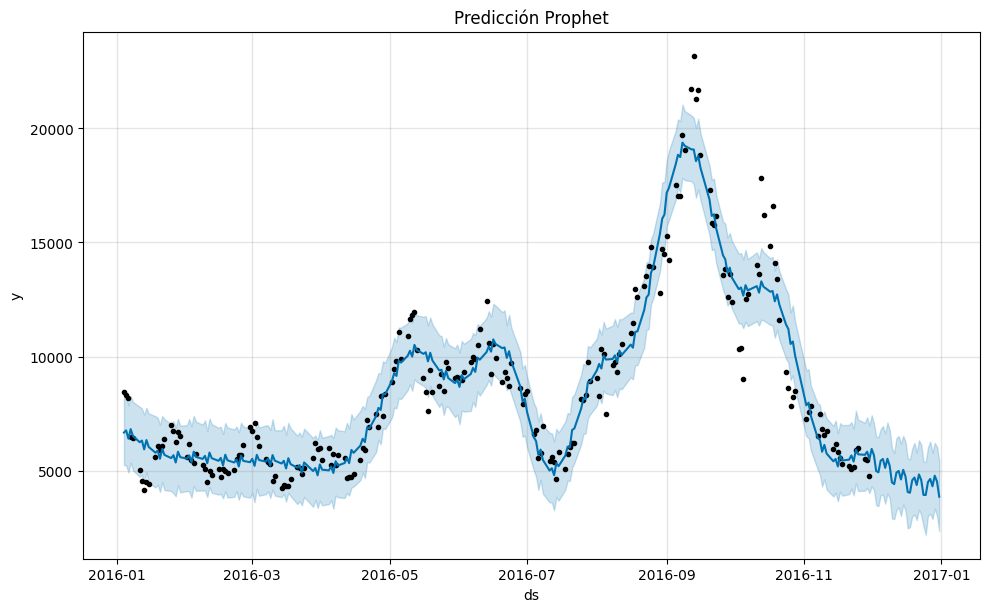

,ds,yhat,yhat_lower,yhat_upper
257,2016-12-27,4635.164388,3106.721078,6275.063054
258,2016-12-28,4312.781322,2882.772126,5784.409221
259,2016-12-29,4777.765178,3340.421934,6218.486650
260,2016-12-30,4526.018783,3015.824710,6046.792169
261,2016-12-31,3856.685764,2341.327485,5437.041348


In [ ]:
def entrenar_prophet(serie, train_end_date, periods=30, freq='D', plot=True):
    # Preparar DataFrame para Prophet
    dfp = serie.reset_index().rename(columns={'fecha':'ds','precio':'y'})
    dfp = dfp.dropna()
    train = dfp[dfp['ds']<=pd.to_datetime(train_end_date)].copy()
    m = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
    m.fit(train)
    future = m.make_future_dataframe(periods=periods, freq=freq)
    forecast = m.predict(future)
    if plot:
        fig = m.plot(forecast)
        plt.title('Predicción Prophet')
        plt.show()
    return m, forecast

# Ejemplo: entrenar hasta 2016-11-30 y predecir 31 días
m, forecast = entrenar_prophet(serie_tomate, '2016-11-30', periods=31)
forecast[['ds','yhat','yhat_lower','yhat_upper']].tail()

## 5) Evaluación: comparar valores reales vs predichos para un mes seleccionado

La siguiente función toma el `forecast` de Prophet y lo compara contra los valores reales del mes que elijas (ej: diciembre 2016).

In [ ]:
def comparar_mes_real_predicho(serie, forecast, year_month):
    # year_month en formato 'YYYY-MM'
    start = pd.to_datetime(year_month + '-01')
    end = start + pd.offsets.MonthEnd(1)
    # Extraer predicción para el rango
    pred = forecast.set_index('ds')[['yhat']]
    pred = pred.loc[start:end].rename(columns={'yhat':'pred'})
    real = serie.loc[start:end].rename(columns={'precio':'real'})
    comp = real.join(pred, how='left')
    comp = comp.reset_index()
    comp['diff'] = comp['pred'] - comp['real']
    comp['diff_pct'] = comp['diff'] / comp['real'] * 100
    return comp

# Ejemplo comparando diciembre 2016
comp_dec_2016 = comparar_mes_real_predicho(serie_tomate, forecast, '2016-12')
comp_dec_2016.head(15)

print('\nMétricas para el mes:')
print('MAE:', mean_absolute_error(comp_dec_2016['real'].dropna(), comp_dec_2016['pred'].dropna()))
print('RMSE:', mean_squared_error(comp_dec_2016['real'].dropna(), comp_dec_2016['pred'].dropna()))


Métricas para el mes:
MAE: 655.6919365869259
RMSE: 700292.8731334831


## 6) Modelo 2: Random Forest con features de rezago

Crearemos características de lag (rezagos) y valores de ventana, entrenaremos RandomForest y compararemos.

In [ ]:
def crear_features_lags(serie, lags=[1,2,3,7,14], windows=[7,14]):
    df = serie.copy().reset_index()
    df = df.rename(columns={'fecha':'ds','precio':'y'})
    df = df.sort_values('ds')
    for l in lags:
        df[f'lag_{l}'] = df['y'].shift(l)
    for w in windows:
        df[f'roll_mean_{w}'] = df['y'].rolling(w).mean()
    df['dayofweek'] = df['ds'].dt.dayofweek
    df['month'] = df['ds'].dt.month
    df = df.dropna()
    return df

# Crear features y entrenar
df_feat = crear_features_lags(serie_tomate)
train_df = df_feat[df_feat['ds']<=pd.to_datetime('2016-11-30')]
test_df = df_feat[(df_feat['ds']>pd.to_datetime('2016-11-30')) & (df_feat['ds']<=pd.to_datetime('2016-12-31'))]

features = [c for c in train_df.columns if c not in ['ds','y']]
X_train = train_df[features]
y_train = train_df['y']
X_test = test_df[features]
y_test = test_df['y']

rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print('MAE RF:', mean_absolute_error(y_test, y_pred_rf))
print('RMSE RF:', mean_squared_error(y_test, y_pred_rf))

# Mostrar comparación diaria
comp_rf = pd.DataFrame({'ds': test_df['ds'], 'real': y_test.values, 'pred_rf': y_pred_rf})
comp_rf.head()

MAE RF: 475.6383154851253
RMSE RF: 309817.48740886454


,ds,real,pred_rf
231,2016-12-01,4230.287425,5062.710889
232,2016-12-02,4076.988920,4824.063238
233,2016-12-05,4064.625000,4692.279669
234,2016-12-06,5301.002270,4595.379757
235,2016-12-07,5545.273955,5109.471501


## 7) Modelo 3: LSTM (Deep Learning) — opcional avanzado

Se muestra un pipeline básico para entrenar una LSTM sobre la serie. Requiere mayor ajuste de hiperparámetros y recursos.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

def crear_sequences(values, window=14):
    X, y = [], []
    for i in range(len(values)-window):
        X.append(values[i:i+window])
        y.append(values[i+window])
    # Add feature dimension even if it's 1
    return np.array(X).reshape(len(X), window, 1), np.array(y)

# Preparar datos
serie_values = serie_tomate['precio'].dropna().values
window = 14
X, y = crear_sequences(serie_values, window=window)

# Escalar X
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)

# Escalar y
scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()


# Split
split_idx = int(len(X_scaled)*0.8)
X_train_lstm, X_test_lstm = X_scaled[:split_idx], X_scaled[split_idx:]
y_train_lstm, y_test_lstm = y_scaled[:split_idx], y_scaled[split_idx:]

# Modelo LSTM simple
model = Sequential()
model.add(LSTM(64, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Entrenar (nota: puede tardar dependiendo del tamaño de datos)
model.fit(X_train_lstm, y_train_lstm, validation_split=0.2, epochs=50, batch_size=32, callbacks=[es])

print('Pipeline LSTM preparado. La ejecución del entrenamiento real está comentada por tiempo de ejecución.')

# Make predictions
y_pred_lstm_scaled = model.predict(X_test_lstm)
y_pred_lstm = scaler_y.inverse_transform(y_pred_lstm_scaled).flatten()

# Get the corresponding dates for the test set
test_dates_lstm = serie_tomate.dropna().iloc[split_idx + window:].index

# Create a DataFrame for LSTM predictions
lstm_pred_df = pd.DataFrame({'ds': test_dates_lstm, 'pred_lstm': y_pred_lstm})

Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 0.4365 - val_loss: 0.1729
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1460 - val_loss: 0.1435
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1239 - val_loss: 0.1281
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1207 - val_loss: 0.1265
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0944 - val_loss: 0.1165
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0914 - val_loss: 0.1050
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0886 - val_loss: 0.1032
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0825 - val_loss: 0.1040
Epoch 9/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0731 - val_loss: 0.1004
Epoch 10/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0782 - val_loss: 0.1005
Epoch 11/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0737 - val_loss: 0.1023
Epoch 12/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0

## 8) Comparación final y exportación

Uniremos las predicciones y crearemos una tabla comparativa para el mes seleccionado, además de exportar los resultados a CSV/PDF si lo deseas.

In [ ]:
# Unir predicciones Prophet, RF y LSTM para el mes de diciembre 2016 (ejemplo)

# Predicción Prophet (extraer y filtrar)
prop_pred = forecast.set_index('ds')[['yhat']]
prop_pred = prop_pred.loc['2016-12-01':'2016-12-31'].rename(columns={'yhat':'pred_prophet'})

# RF predictions (already filtered for Dec 2016)
rf_df = comp_rf.set_index('ds')[['pred_rf','real']]
rf_df.index = pd.to_datetime(rf_df.index)

# LSTM predictions (filter for Dec 2016)
lstm_pred = lstm_pred_df.set_index('ds')[['pred_lstm']]
lstm_pred = lstm_pred.loc['2016-12-01':'2016-12-31']


comp_all = rf_df.join(prop_pred, how='left')
comp_all = comp_all.join(lstm_pred, how='left') # Join LSTM predictions
comp_all = comp_all.reset_index().rename(columns={'index':'fecha'})

# Mostrar tabla y métricas
display(comp_all.head())

print('\nMétricas para el mes:')

# Calculate MAE
mae_prophet = mean_absolute_error(comp_all['real'].dropna(), comp_all['pred_prophet'].dropna())
mae_rf = mean_absolute_error(comp_all['real'].dropna(), comp_all['pred_rf'].dropna())

print('MAE Prophet (mes):', mae_prophet)
print('MAE RF (mes):', mae_rf)

# Check if there are any non-null LSTM predictions for the selected month before calculating MAE
mae_lstm = None
if comp_all['pred_lstm'].dropna().shape[0] > 0:
    mae_lstm = mean_absolute_error(comp_all['real'].dropna(), comp_all['pred_lstm'].dropna())
    print('MAE LSTM (mes):', mae_lstm)
else:
    print('MAE LSTM (mes): No LSTM predictions available for the selected month.')

# Calculate average real price for the month
avg_real_price = comp_all['real'].dropna().mean()

# Calculate MAE as a percentage of the average real price
if avg_real_price > 0:
    print(f'\nMAE Prophet (% del precio promedio real): {mae_prophet / avg_real_price * 100:.2f}%')
    print(f'MAE RF (% del precio promedio real): {mae_rf / avg_real_price * 100:.2f}%')
    if mae_lstm is not None:
        print(f'MAE LSTM (% del precio promedio real): {mae_lstm / avg_real_price * 100:.2f}%')
else:
    print('\nNo se puede calcular el porcentaje de MAE porque el precio promedio real es cero.')


# Guardar a CSV
output_path = '/content/drive/MyDrive/Semestre 2025-2/CAPSTONE/agrochile/modelo IA/comparacion_predicciones_dec2016.csv'
comp_all.to_csv(output_path, index=False)
print(f'Archivo guardado en {output_path}')

,ds,pred_rf,real,pred_prophet,pred_lstm
0,2016-12-01,5062.710889,4230.287425,5950.196050,NaN
1,2016-12-02,4824.063238,4076.988920,5677.671436,NaN
2,2016-12-05,4692.279669,4064.625000,5437.069859,NaN
3,2016-12-06,4595.379757,5301.002270,5508.418024,NaN
4,2016-12-07,5109.471501,5545.273955,5121.023225,NaN



Métricas para el mes:
MAE Prophet (mes): 655.6919365869259
MAE RF (mes): 475.6383154851253
MAE LSTM (mes): No LSTM predictions available for the selected month.
Archivo guardado en /content/drive/MyDrive/Semestre 2025-2/CAPSTONE/agrochile/modelo IA/comparacion_predicciones_dec2016.csv


## 9) Siguientes pasos recomendados

- Extender el periodo de entrenamiento (usar 2000 hasta la fecha) para mayor robustez.
- Modelar por mercado/región si interesa obtener predicciones locales (en lugar del promedio nacional).
- Ajustar hiperparámetros de Prophet, RandomForest y LSTM para mejorar performance.
- Implementar pipeline ETL automatizado para actualización diaria desde ODEPA.

---

**Fin del notebook base.**
